**Scheduling Problem**

Random Space Time Network Instance_E

**Step 01 Generating a Space Time Network**

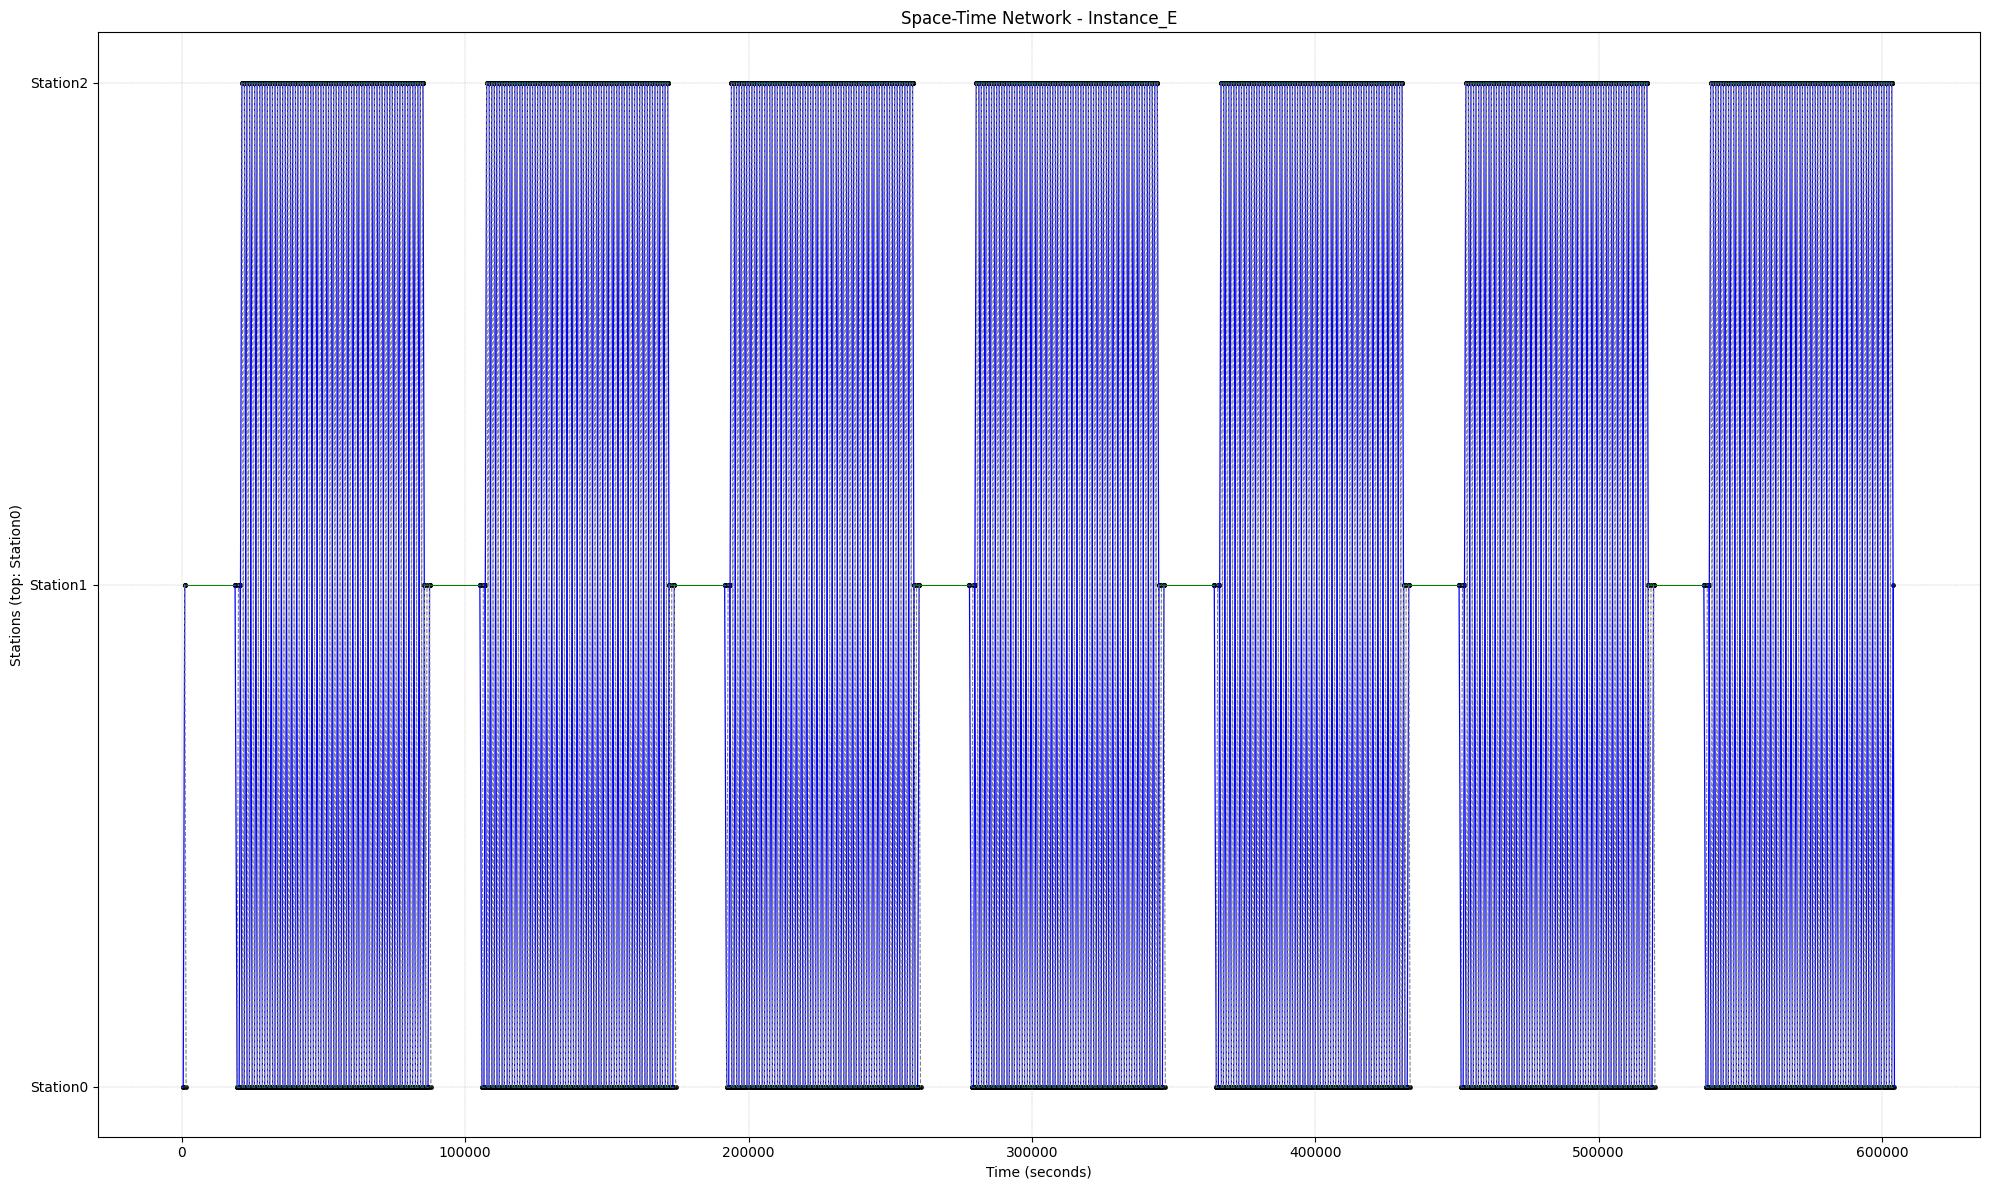

Network Summary
Number of nodes       : 1636
Number of edges       : 2124
Computation time (s)  : 41.543


In [1]:
# Load required libraries
import json  # Used to read and parse JSON files
import matplotlib.pyplot as plt  # Used for plotting the space-time network
import re  # Used for natural sorting of station names like Station1, Station2, Station10
import time  # Used to measure computation time
import matplotlib.ticker as ticker  # (Optional) used for custom formatting of x-axis ticks

# Start the timer to measure total computation time
start_time = time.time()

# Open and load the JSON file containing the instance data for stations, trips, and empty runs
with open("Instance_E.json") as f:
    data = json.load(f)

# Define a helper function that creates a sorting key for natural sorting (e.g., Station2 before Station10)
def natural_key(s):
    return [int(text) if text.isdigit() else text for text in re.split('(\d+)', s)]

# Extract and sort all station names using natural sorting
stations = sorted([s["Name"] for s in data["StationList"]], key=natural_key)

# Create a dictionary mapping each station name to a corresponding y-axis index (0, 1, ..., 33)
station_to_y = {name: i for i, name in enumerate(stations)}

# Sort all trips based on their start times
trips = sorted(data["TripList"], key=lambda x: x["StartTime"])

# Extract the empty run data which contains light travel durations between station pairs
empty_runs = data["EmptyRunData"]

# Initialize lists to store different types of arcs (edges) and special nodes
train_arcs = []          # Arcs representing productive trips (trains with passengers)
light_arcs_arrival = []  # Arcs representing light vehicle travel after completing a trip
light_arcs_source = []   # Arcs representing vehicle repositioning from source to first trip
ground_arcs = []         # Arcs representing idle waiting time at a station
source_nodes = []        # Artificial source nodes (before each trip)
sink_nodes = []          # Artificial sink nodes (after each trip)
nodes_set = set()        # Set to store all unique (time, station index) pairs (i.e., nodes)

# Step 1: Create artificial source and sink nodes for each trip
for trip in trips:
    source_nodes.append((trip["StartTime"] - 1, station_to_y[trip["Origin"]]))  # source node before trip starts
    sink_nodes.append((trip["EndTime"] + 1, station_to_y[trip["Destination"]]))  # sink node after trip ends

# Step 2: Create productive train arcs
for trip in trips:
    u = (trip["StartTime"], station_to_y[trip["Origin"]])
    v = (trip["EndTime"], station_to_y[trip["Destination"]])
    train_arcs.append((u, v))
    nodes_set.update([u, v])  # store nodes

# Step 3: Create light arcs from trip end to future trip start
for trip_a in trips:
    for trip_b in trips:
        if trip_a["Id"] != trip_b["Id"] and trip_a["EndTime"] < trip_b["StartTime"]:
            key = f"{trip_a['Destination']},{trip_b['Origin']}"
            if trip_a["Destination"] != trip_b["Origin"] and key in empty_runs:
                transfer_time = empty_runs[key]["Duration"]
                if trip_a["EndTime"] + transfer_time <= trip_b["StartTime"]:
                    u = (trip_a["EndTime"], station_to_y[trip_a["Destination"]])
                    v = (trip_a["EndTime"] + transfer_time, station_to_y[trip_b["Origin"]])
                    light_arcs_arrival.append((u, v))
                    nodes_set.update([u, v])
                    break

# Step 4: Create light arcs from artificial source to feasible trip origin
for src in source_nodes:
    t0, y0 = src
    for trip in trips:
        key = f"{stations[y0]},{trip['Origin']}"
        if key in empty_runs and t0 < trip["StartTime"]:
            duration = empty_runs[key]["Duration"]
            if t0 + duration <= trip["StartTime"]:
                u = src
                v = (t0 + duration, station_to_y[trip["Origin"]])
                light_arcs_source.append((u, v))
                nodes_set.update([u, v])
                break

# Step 5: Create ground arcs between end of one trip and start of another at same station
for trip_a in trips:
    for trip_b in trips:
        if trip_a["Destination"] == trip_b["Origin"] and trip_b["StartTime"] > trip_a["EndTime"]:
            u = (trip_a["EndTime"], station_to_y[trip_a["Destination"]])
            v = (trip_b["StartTime"], station_to_y[trip_b["Origin"]])
            ground_arcs.append((u, v))
            nodes_set.update([u, v])
            break

# Start plotting the space-time network
plt.figure(figsize=(20, 12))

# Draw productive train arcs (blue)
for u, v in train_arcs:
    plt.plot([u[0], v[0]], [u[1], v[1]], color='blue', linewidth=0.9)

# Draw light arcs after trip end (dashed gray)
for u, v in light_arcs_arrival:
    plt.plot([u[0], v[0]], [u[1], v[1]], color='gray', linestyle='dashed', linewidth=0.8)

# Draw light arcs from source node (dotted dark gray)
for u, v in light_arcs_source:
    plt.plot([u[0], v[0]], [u[1], v[1]], color='darkgray', linestyle='dotted', linewidth=0.8)

# Draw ground arcs (green)
for u, v in ground_arcs:
    plt.plot([u[0], v[0]], [u[1], v[1]], color='green', linestyle='solid', linewidth=0.7)

# Scatter plot all nodes for clarity
for (u, v) in train_arcs + light_arcs_arrival + light_arcs_source + ground_arcs:
    plt.scatter([u[0], v[0]], [u[1], v[1]], s=6, color='black')

# Configure y-axis with station names in top-down order
plt.yticks(range(len(stations)), stations)

# Set labels and title
plt.xlabel("Time (seconds)")
plt.ylabel("Stations (top: Station0)")
plt.title("Space-Time Network - Instance_E")

# Add grid and tighten layout
plt.grid(True, linestyle='--', linewidth=0.3)
plt.tight_layout()

# Show the final plot
plt.show()

# Calculate total edges and computation time
total_edges = len(train_arcs) + len(light_arcs_arrival) + len(light_arcs_source) + len(ground_arcs)
end_time_calc = time.time()

# Print network statistics
print("Network Summary")
print(f"Number of nodes       : {len(nodes_set)}")
print(f"Number of edges       : {total_edges}")
print(f"Computation time (s)  : {round(end_time_calc - start_time, 3)}")


**Step 02 Costing Calculation and Vehicles Calculation Using Pulp**

Pulp Installation for Mixed Integer Program Optimization

In [2]:
# Install PuLP
!pip install pulp

# Load libraries
import json, re
import pulp
import pandas as pd

# Load JSON file
with open("Instance_E.json") as f:
    data = json.load(f)

# Cost parameters
C_TU = 1000
C_Light = 0.10

# Parse stations and trips
stations = sorted(
    [s["Name"] for s in data["StationList"]],
    key=lambda s: [int(t) if t.isdigit() else t for t in re.split("(\d+)", s)]
)
station_index = {name: i for i, name in enumerate(stations)}

trips = sorted(data["TripList"], key=lambda x: x["StartTime"])
trip_ids = [trip["Id"] for trip in trips]
trip_map = {trip["Id"]: trip for trip in trips}
empty_runs = data["EmptyRunData"]

# Optimization model
model = pulp.LpProblem("RollingStockCirculationPlanning", pulp.LpMinimize)

x = {trip["Id"]: pulp.LpVariable(f"x_{trip['Id']}", cat="Binary") for trip in trips}
vehicles = {trip["Id"]: pulp.LpVariable(f"veh_{trip['Id']}", cat="Binary") for trip in trips}
z = {}

# Generate light travel arcs
for i, trip_a in enumerate(trips):
    for j, trip_b in enumerate(trips):
        if i != j and trip_a["EndTime"] < trip_b["StartTime"]:
            key = f"{trip_a['Destination']},{trip_b['Origin']}"
            if key in empty_runs:
                ttime = empty_runs[key]["Duration"]
                if trip_a["EndTime"] + ttime <= trip_b["StartTime"]:
                    arc = f"{trip_a['Id']}_{trip_b['Id']}"
                    z[arc] = pulp.LpVariable(f"z_{arc}", cat="Binary")

# Objective
model += (
    pulp.lpSum([vehicles[trip["Id"]] for trip in trips]) * C_TU +
    pulp.lpSum([
        z[arc] *
        empty_runs[f"{trip_map[int(arc.split('_')[0])]['Destination']},{trip_map[int(arc.split('_')[1])]['Origin']}"]["Distance"] *
        C_Light for arc in z
    ])
)

# Constraints
for trip in trips:
    model += x[trip["Id"]] == 1

for trip in trips:
    incoming = [z[arc] for arc in z if int(arc.split('_')[1]) == trip["Id"]]
    model += vehicles[trip["Id"]] + pulp.lpSum(incoming) >= x[trip["Id"]]

for trip in trips:
    outgoing = [z[arc] for arc in z if int(arc.split('_')[0]) == trip["Id"]]
    model += pulp.lpSum(outgoing) <= 1

# Solve
model.solve(pulp.PULP_CBC_CMD(msg=0))

# Result
num_vehicles = sum(v.varValue for v in vehicles.values())
light_cost = sum(
    z[arc].varValue *
    empty_runs[f"{trip_map[int(arc.split('_')[0])]['Destination']},{trip_map[int(arc.split('_')[1])]['Origin']}"]["Distance"] *
    C_Light for arc in z
)
traction_cost = num_vehicles * C_TU
total_cost = traction_cost + light_cost

# Display
results = {
    "Total Cost": round(total_cost, 2),
    "Traction Unit Cost": round(traction_cost, 2),
    "Light Travel Cost": round(light_cost, 2),
    "Deadheading Cost": 0.00,
    "Number of Vehicles Used": int(num_vehicles)
}
pd.DataFrame([results])


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 61.6 MB/s eta 0:00:00


,Total Cost,Traction Unit Cost,Light Travel Cost,Deadheading Cost,Number of Vehicles Used
0,2000.0,2000.0,0.0,0.0,2


**`Schedule Calculator`**


In [3]:
# STEP 1: Install pulp (for Google Colab; skip if already installed)
!pip install pulp

# STEP 2: Import required libraries
import json           # For reading the JSON file
import re             # For sorting station names naturally
import pulp           # For defining and solving the optimization model
import pandas as pd   # For creating and displaying schedule tables
from pulp import LpStatus  # For checking the model solution status

# STEP 3: Load data from the JSON file
with open("Instance_E.json") as f:
    data = json.load(f)

# STEP 4: Define cost parameters
C_TU = 1000       # Cost for using a train unit
C_Light = 0.10    # Cost per km for light (empty) travel

# STEP 5: Prepare and sort stations
stations = sorted(
    [s["Name"] for s in data["StationList"]],
    key=lambda s: [int(t) if t.isdigit() else t for t in re.split("(\d+)", s)]
)
station_index = {name: i for i, name in enumerate(stations)}

# STEP 6: Extract trips and empty run data
trips = sorted(data["TripList"], key=lambda x: x["StartTime"])
trip_map = {trip["Id"]: trip for trip in trips}
empty_runs = data["EmptyRunData"]

# STEP 7: Define the optimization model
model = pulp.LpProblem("RollingStock", pulp.LpMinimize)

# Binary variable for each trip: 1 if performed
x = {trip["Id"]: pulp.LpVariable(f"x_{trip['Id']}", cat="Binary") for trip in trips}

# Binary variable for vehicle usage: 1 if a new train starts with this trip
vehicles = {trip["Id"]: pulp.LpVariable(f"veh_{trip['Id']}", cat="Binary") for trip in trips}

# Binary variables for light connections between trips
z = {}
for i, a in enumerate(trips):
    for j, b in enumerate(trips):
        if i != j and a["EndTime"] < b["StartTime"]:
            key = f"{a['Destination']},{b['Origin']}"
            if key in empty_runs:
                dt = empty_runs[key]["Duration"]
                if a["EndTime"] + dt <= b["StartTime"]:
                    arc = f"{a['Id']}_{b['Id']}"
                    z[arc] = pulp.LpVariable(f"z_{arc}", cat="Binary")

# STEP 8: Define objective function to minimize total cost
model += (
    pulp.lpSum([vehicles[tid] for tid in x]) * C_TU +
    pulp.lpSum([
        z[arc] * empty_runs[
            f"{trip_map[int(arc.split('_')[0])]['Destination']},{trip_map[int(arc.split('_')[1])]['Origin']}"
        ]["Distance"] * C_Light for arc in z
    ])
)

# STEP 9: Add constraints
# Ensure each trip is covered
for trip in trips:
    model += x[trip["Id"]] == 1

# A trip is covered either by a new vehicle or from a previous trip via light travel
for trip in trips:
    incoming = [z[arc] for arc in z if int(arc.split("_")[1]) == trip["Id"]]
    model += vehicles[trip["Id"]] + pulp.lpSum(incoming) >= x[trip["Id"]]

# A trip connects to at most one next trip
for trip in trips:
    outgoing = [z[arc] for arc in z if int(arc.split("_")[0]) == trip["Id"]]
    model += pulp.lpSum(outgoing) <= 1

# STEP 10: Solve the model
model.solve(pulp.PULP_CBC_CMD(msg=0))

# STEP 11: Check if solution is feasible
status = LpStatus[model.status]
print(f"\n🔍 Model Status: {status}")
if status != "Optimal":
    print(" No feasible or optimal solution found.")
else:
    print(" Feasible and optimal solution found.")

# STEP 12: Assign Train IDs
trip_to_train = {}
train_counter = 1
outgoing_map = {int(arc.split('_')[0]): int(arc.split('_')[1]) for arc in z if z[arc].varValue == 1}
visited = set()

for trip in trips:
    tid = trip["Id"]
    if tid not in visited:
        current_train = f"Train_{train_counter}"
        while tid in trip_map:
            visited.add(tid)
            trip_to_train[tid] = current_train
            tid = outgoing_map.get(tid, None)
            if tid is None or tid in visited:
                break
        train_counter += 1

# STEP 13: Build the full trip and light travel schedule
full_schedule = []

# Add train trips
for tid, var in x.items():
    if var.varValue == 1:
        trip = trip_map[tid]
        full_schedule.append({
            "Train": trip_to_train[tid],
            "Type": "Train Trip",
            "From": trip["Origin"],
            "To": trip["Destination"],
            "StartTime": trip["StartTime"],
            "EndTime": trip["EndTime"]
        })

# Add light travel trips
light_travel_cost = 0
for arc, var in z.items():
    if var.varValue == 1:
        from_id, to_id = map(int, arc.split("_"))
        trip_a = trip_map[from_id]
        trip_b = trip_map[to_id]
        key = f"{trip_a['Destination']},{trip_b['Origin']}"
        dur = empty_runs[key]["Duration"]
        dist = empty_runs[key]["Distance"]
        cost = dist * C_Light
        light_travel_cost += cost
        full_schedule.append({
            "Train": trip_to_train[from_id],
            "Type": "Light Travel",
            "From": trip_a["Destination"],
            "To": trip_b["Origin"],
            "StartTime": trip_a["EndTime"],
            "EndTime": trip_a["EndTime"] + dur
        })

# STEP 14: Display the final schedule
full_schedule = sorted(full_schedule, key=lambda x: x["StartTime"])
df_schedule = pd.DataFrame(full_schedule)
print("\n Complete Trip and Light Travel Schedule:")
print(df_schedule.to_string(index=False))

# STEP 15: Print cost breakdown
traction_units = sum([vehicles[tid].varValue for tid in vehicles])
traction_cost = traction_units * C_TU
total_cost = pulp.value(model.objective)

print("\n Cost Breakdown:")
print(f"Total Cost           : {total_cost:.2f}")
print(f"Traction Unit Cost   : {traction_cost:.2f}")
print(f"Light Travel Cost    : {light_travel_cost:.2f}")
print(f"Number of Vehicles   : {int(traction_units)}")



🔍 Model Status: Optimal
 Feasible and optimal solution found.

 Complete Trip and Light Travel Schedule:
  Train         Type     From       To  StartTime  EndTime
Train_1   Train Trip Station0 Station1        480     1020
Train_1 Light Travel Station1 Station1       1020     1020
Train_1   Train Trip Station1 Station0      18780    19500
Train_1 Light Travel Station0 Station0      19500    19500
Train_1   Train Trip Station0 Station2      20220    21180
Train_2   Train Trip Station1 Station0      20580    21300
Train_1 Light Travel Station2 Station2      21180    21180
Train_2 Light Travel Station0 Station0      21300    21300
Train_2   Train Trip Station0 Station2      22020    22980
Train_1   Train Trip Station2 Station0      22080    23040
Train_2 Light Travel Station2 Station2      22980    22980
Train_1 Light Travel Station0 Station0      23040    23040
Train_1   Train Trip Station0 Station2      23820    24780
Train_2   Train Trip Station2 Station0      23880    24840
Train_1 L

**Convert List_A to a CSV File**

In [4]:
import pandas as pd

# Convert full_schedule (a list of dicts) into a DataFrame
df_schedule = pd.DataFrame(full_schedule)

# Save to CSV
df_schedule.to_csv("full_schedule_Instance_E.csv", index=False)

# For Google Colab: provide download link
from google.colab import files
files.download("full_schedule_Instance_E.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

/tmp/ipython-input-11-3531307976.py:21: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab20', len(train_ids))


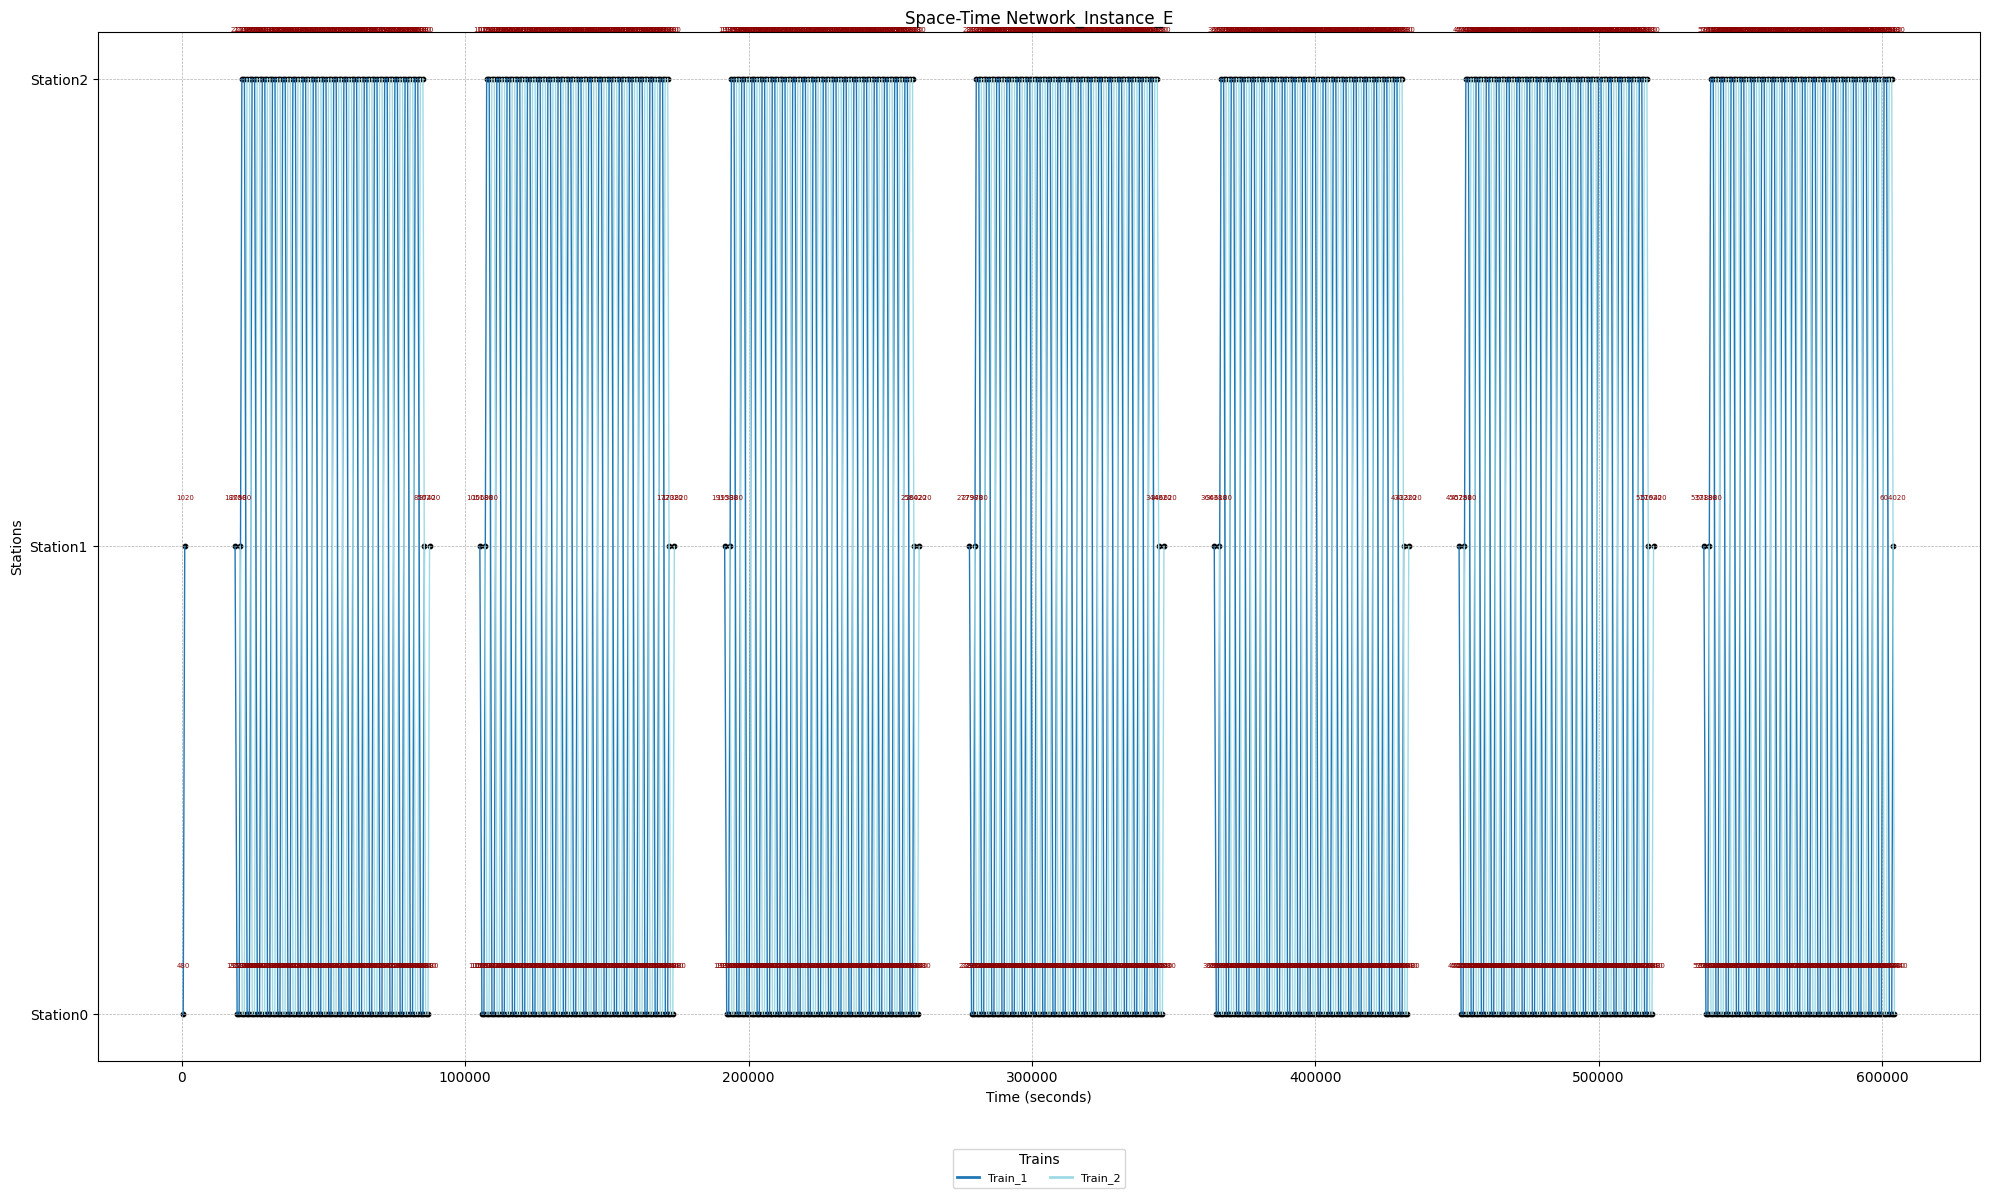


===== Network Summary =====
Total Nodes      : 1064
Total Edges      : 1062
Execution Time   : 22.154 seconds


In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.lines as mlines
import time

# Start timer
start_time = time.time()

# Load schedule
df_schedule = pd.read_csv("full_schedule_Instance_E.csv")

# Step 1: Map stations to Y-axis positions
stations = sorted(set(df_schedule["From"]).union(set(df_schedule["To"])))
station_to_y = {station: i for i, station in enumerate(stations)}

# Step 2: Predefine train IDs
train_ids = [f"Train_{i}" for i in range(1, 3)]

# Step 3: Assign each train a unique color
cmap = cm.get_cmap('tab20', len(train_ids))
train_to_color = {train: cmap(i) for i, train in enumerate(train_ids)}

# Step 4: Initialize plot and track nodes/edges
plt.figure(figsize=(20, 12))
nodes = set()
edges = []

# Step 5: Plot edges and store nodes/edges
for _, row in df_schedule.iterrows():
    from_station = row["From"]
    to_station = row["To"]
    start_time_trip = row["StartTime"]
    end_time_trip = row["EndTime"]
    train = row["Train"]
    edge_type = row["Type"]

    u = (start_time_trip, station_to_y[from_station])
    v = (end_time_trip, station_to_y[to_station])

    nodes.update([u, v])
    edges.append((u, v))

    color = train_to_color.get(train, 'black')
    linestyle = '-' if edge_type == "Train Trip" else '--'
    plt.plot([u[0], v[0]], [u[1], v[1]], color=color, linestyle=linestyle, linewidth=1)

# Step 6: Plot nodes
for t, y in nodes:
    plt.scatter(t, y, color='black', s=10)
    plt.text(t, y + 0.1, f'{t}', fontsize=5, ha='center', color='darkred')

# Step 7: Axis formatting
plt.yticks(list(station_to_y.values()), list(station_to_y.keys()))
plt.xlabel("Time (seconds)")
plt.ylabel("Stations")
plt.title("Space-Time Network_Instance_E")
plt.grid(True, linestyle='--', linewidth=0.5)

# Step 8: Legend
legend_lines = [
    mlines.Line2D([], [], color=train_to_color[train], linewidth=2, label=train)
    for train in train_ids
]
plt.legend(handles=legend_lines, title="Trains", loc='upper center', bbox_to_anchor=(0.5, -0.08),
           ncol=6, fontsize=8, title_fontsize=10, frameon=True)

plt.tight_layout()
plt.show()

# End timer
end_time = time.time()

# Step 9: Print summary
print("\n===== Network Summary =====")
print(f"Total Nodes      : {len(nodes)}")
print(f"Total Edges      : {len(edges)}")
print(f"Execution Time   : {round(end_time - start_time, 3)} seconds")


**Robustness Calculation**

In [6]:
# STEP 01: Identify tight connections
# Define threshold (e.g., 300 seconds = 5 minutes)
TIGHT_THRESHOLD = 300  # seconds

# Extract only productive train trips for each train
train_trips = df_schedule[df_schedule["Type"] == "Train Trip"].copy()
train_trips.sort_values(by=["Train", "StartTime"], inplace=True)

# Find consecutive trips by the same train
tight_connections = []
for train_id, group in train_trips.groupby("Train"):
    trips = group.sort_values("StartTime").reset_index(drop=True)
    for i in range(len(trips) - 1):
        current_end = trips.loc[i, "EndTime"]
        next_start = trips.loc[i + 1, "StartTime"]
        connection_time = next_start - current_end
        if connection_time <= TIGHT_THRESHOLD:
            tight_connections.append({
                "Train": train_id,
                "FromTripEnd": current_end,
                "ToTripStart": next_start,
                "ConnectionTime": connection_time,
                "FromStation": trips.loc[i, "To"],
                "ToStation": trips.loc[i + 1, "From"]
            })

# Display the tight connections
df_tight = pd.DataFrame(tight_connections)
print(f"\n Tight Connections (<= {TIGHT_THRESHOLD} seconds): {len(df_tight)} found")
if not df_tight.empty:
    print(df_tight.to_string(index=False))
else:
    print(" No tight connections found.")



 Tight Connections (<= 300 seconds): 0 found
 No tight connections found.


In [7]:
import pandas as pd

# Step 2: Set threshold for tight connections
TIGHT_THRESHOLD = 300  # seconds
BUFFER_TIME = 600      # seconds

# Step 3: Detect tight connections
train_trips = df_schedule[df_schedule["Type"] == "Train Trip"].copy()
train_trips.sort_values(by=["Train", "StartTime"], inplace=True)

tight_connections = []
for train_id, group in train_trips.groupby("Train"):
    trips = group.sort_values("StartTime").reset_index(drop=True)
    for i in range(len(trips) - 1):
        current_end = trips.loc[i, "EndTime"]
        next_start = trips.loc[i + 1, "StartTime"]
        connection_time = next_start - current_end
        if connection_time <= TIGHT_THRESHOLD:
            tight_connections.append({
                "Train": train_id,
                "FromTripEnd": current_end,
                "ToTripStart": next_start,
                "ConnectionTime": connection_time,
                "FromStation": trips.loc[i, "To"],
                "ToStation": trips.loc[i + 1, "From"]
            })

df_tight = pd.DataFrame(tight_connections)

# Step 4: Apply buffer by shifting trips forward
df_buffered = df_schedule.copy()
df_buffered.sort_values(by=["Train", "StartTime"], inplace=True)

for _, row in df_tight.iterrows():
    train_id = row["Train"]
    to_start = row["ToTripStart"]
    affected = df_buffered[
        (df_buffered["Train"] == train_id) &
        (df_buffered["StartTime"] >= to_start)
    ].index
    df_buffered.loc[affected, "StartTime"] += BUFFER_TIME
    df_buffered.loc[affected, "EndTime"] += BUFFER_TIME

# Step 5: Recalculate cost
C_TU = 1000
C_Light = 0.10
traction_units = df_buffered["Train"].nunique()
traction_cost = traction_units * C_TU

light_travel_cost = 0
for _, row in df_buffered[df_buffered["Type"] == "Light Travel"].iterrows():
    key = f"{row['From']},{row['To']}"
    if key in empty_runs:
        dist = empty_runs[key]["Distance"]
        light_travel_cost += dist * C_Light

total_cost = traction_cost + light_travel_cost

# Step 6: Calculate nodes and edges
nodes = set()
edges = 0
for _, row in df_buffered.iterrows():
    u = (row["StartTime"], row["From"])
    v = (row["EndTime"], row["To"])
    nodes.update([u, v])
    edges += 1

# Step 7: Save result
buffered_schedule_path = "schedule_buffered_600s.csv"
df_buffered.to_csv(buffered_schedule_path, index=False)

# Step 8: Summary
print("\n===== ⏱️ Buffered Plan Summary (600s for tight links) =====")
print(f" Tight Connections Found   : {len(df_tight)}")
print(f" Buffer Applied per Link   : {BUFFER_TIME} seconds")
print(f" Trains (Vehicles) Used    : {traction_units}")
print(f" Light Travel Cost         : {round(light_travel_cost, 2)}")
print(f" Total Cost                : {round(total_cost, 2)}")
print(f" Total Edges               : {edges}")
print(f" Total Unique Nodes        : {len(nodes)}")
print(f" Saved to File             : {buffered_schedule_path}")



===== ⏱️ Buffered Plan Summary (600s for tight links) =====
 Tight Connections Found   : 0
 Buffer Applied per Link   : 600 seconds
 Trains (Vehicles) Used    : 2
 Light Travel Cost         : 0.0
 Total Cost                : 2000.0
 Total Edges               : 1062
 Total Unique Nodes        : 1064
 Saved to File             : schedule_buffered_600s.csv


In [8]:
import pandas as pd

# Load the original schedule before buffering
df_schedule = pd.read_csv("full_schedule_Instance_E.csv")


/tmp/ipython-input-9-2850491763.py:76: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab20', len(train_ids))


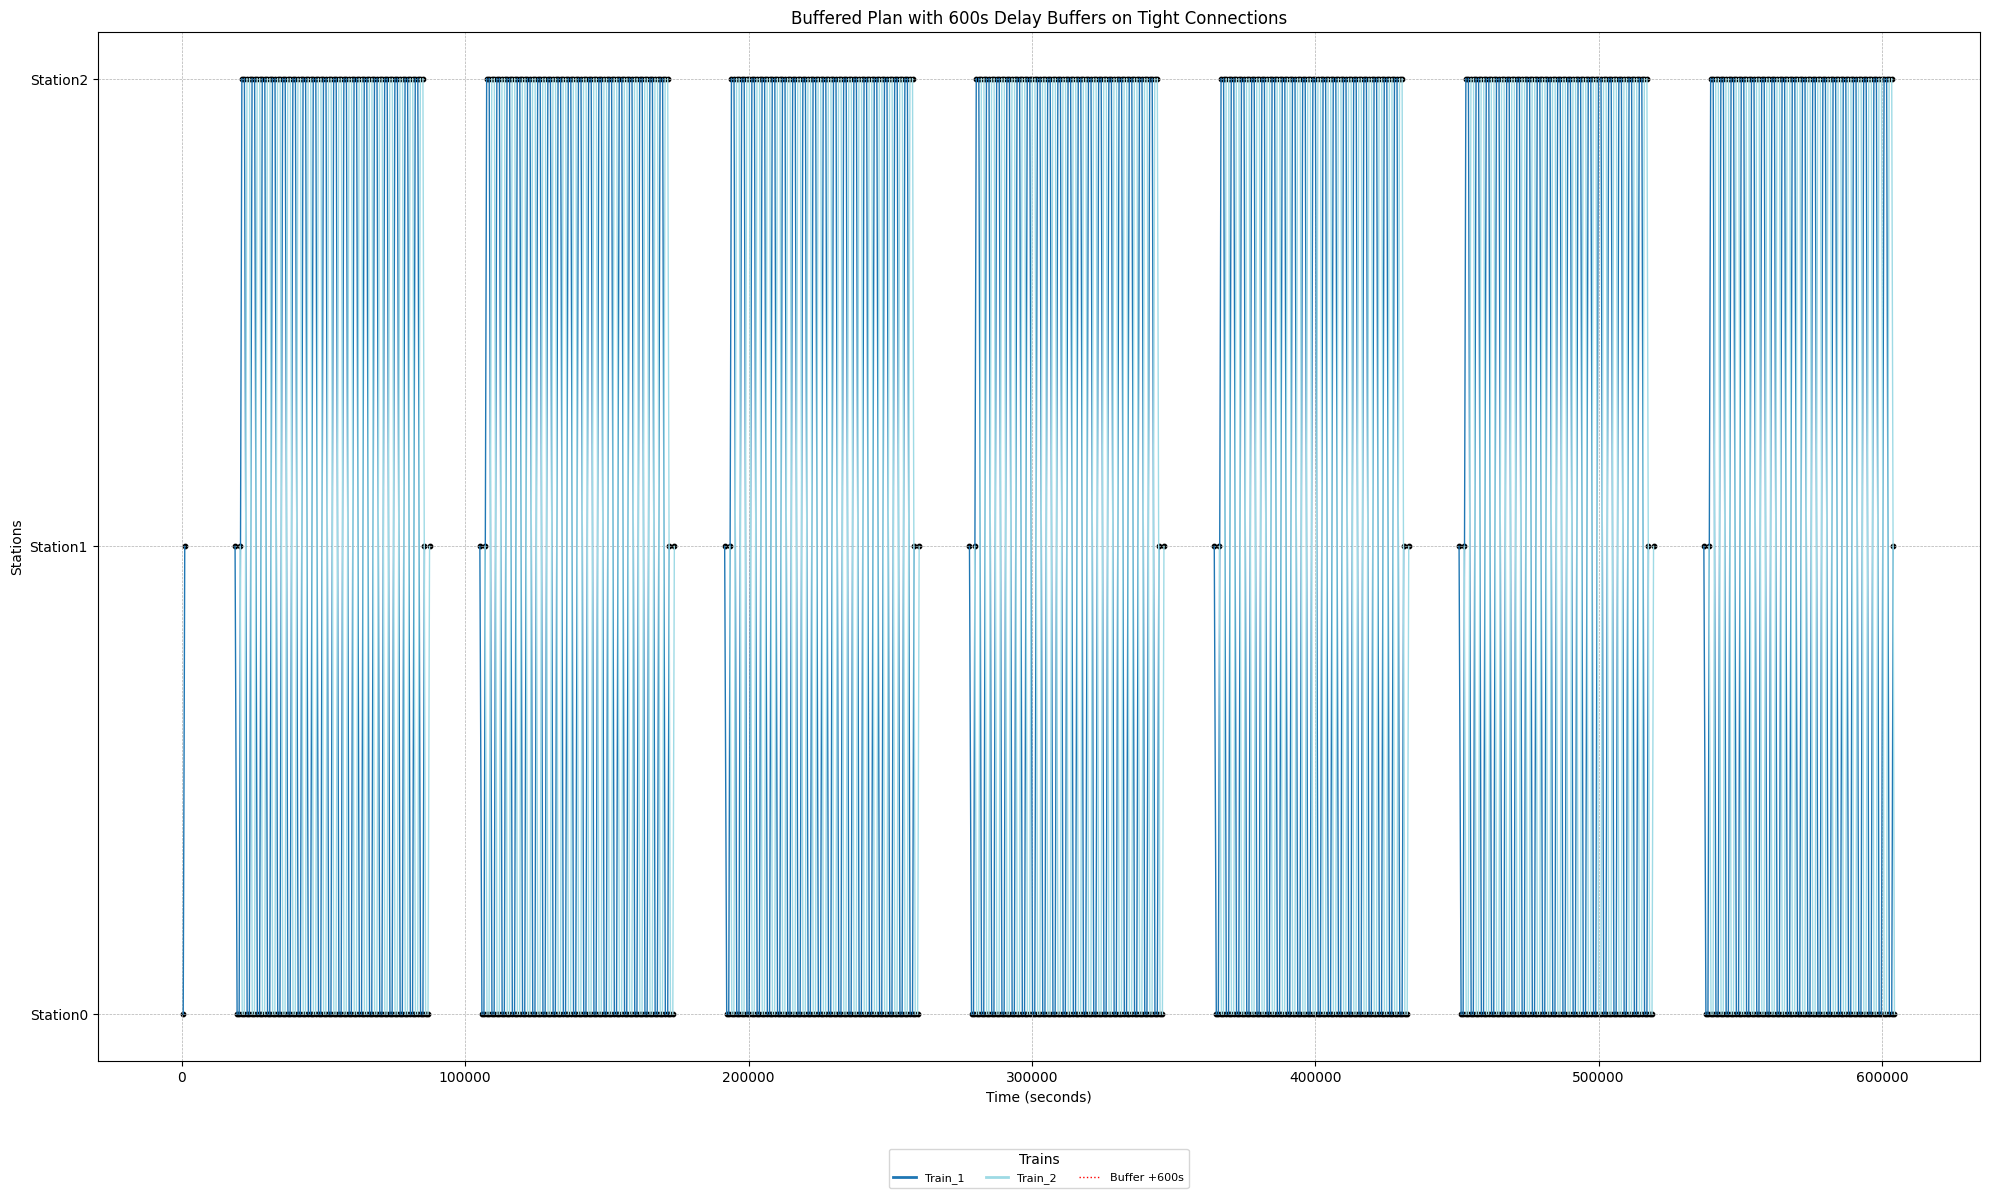


===== ⏱️ Buffered Plan Summary (600s for tight links) =====
 Tight Connections Found   : 0
 Buffer Applied per Link   : 600 seconds
 Trains (Vehicles) Used    : 2
 Light Travel Cost         : 0.0
 Total Cost                : 2000.0
 Total Edges               : 1062
 Total Unique Nodes        : 1064


In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.lines as mlines
import json
import re

# Load JSON data
with open("Instance_E.json") as f:
    data = json.load(f)

# Extract empty runs
empty_runs = data["EmptyRunData"]

# === CONFIGURATION ===
TIGHT_THRESHOLD = 300  # seconds
BUFFER_TIME = 600      # buffer to add after tight connections
C_TU = 1000            # traction unit cost
C_Light = 0.10         # light travel cost per km

# === STEP 1: Detect Tight Connections ===
train_trips = df_schedule[df_schedule["Type"] == "Train Trip"].copy()
train_trips.sort_values(by=["Train", "StartTime"], inplace=True)

tight_connections = []
for train_id, group in train_trips.groupby("Train"):
    trips = group.sort_values("StartTime").reset_index(drop=True)
    for i in range(len(trips) - 1):
        current_end = trips.loc[i, "EndTime"]
        next_start = trips.loc[i + 1, "StartTime"]
        connection_time = next_start - current_end
        if connection_time <= TIGHT_THRESHOLD:
            tight_connections.append({
                "Train": train_id,
                "FromTripEnd": current_end,
                "ToTripStart": next_start,
                "ConnectionTime": connection_time,
                "FromStation": trips.loc[i, "To"],
                "ToStation": trips.loc[i + 1, "From"]
            })

df_tight = pd.DataFrame(tight_connections)

# === STEP 2: Apply Buffer ===
df_buffered = df_schedule.copy()
df_buffered.sort_values(by=["Train", "StartTime"], inplace=True)

for _, row in df_tight.iterrows():
    train_id = row["Train"]
    to_start = row["ToTripStart"]
    affected = df_buffered[
        (df_buffered["Train"] == train_id) &
        (df_buffered["StartTime"] >= to_start)
    ].index
    df_buffered.loc[affected, "StartTime"] += BUFFER_TIME
    df_buffered.loc[affected, "EndTime"] += BUFFER_TIME

# === STEP 3: Recalculate Cost ===
traction_units = df_buffered["Train"].nunique()
traction_cost = traction_units * C_TU

light_travel_cost = 0
for _, row in df_buffered[df_buffered["Type"] == "Light Travel"].iterrows():
    key = f"{row['From']},{row['To']}"
    if key in empty_runs:
        dist = empty_runs[key]["Distance"]
        light_travel_cost += dist * C_Light

total_cost = traction_cost + light_travel_cost

# === STEP 4: Plot with Buffer Annotations ===
stations = sorted(set(df_buffered["From"]).union(set(df_buffered["To"])))
station_to_y = {station: i for i, station in enumerate(stations)}

train_ids = sorted(df_buffered["Train"].unique())
cmap = cm.get_cmap('tab20', len(train_ids))
train_to_color = {train: cmap(i) for i, train in enumerate(train_ids)}

plt.figure(figsize=(20, 12))
nodes = set()

# Plot train arcs
for _, row in df_buffered.iterrows():
    from_station = row["From"]
    to_station = row["To"]
    start = row["StartTime"]
    end = row["EndTime"]
    train = row["Train"]
    typ = row["Type"]

    u = (start, station_to_y[from_station])
    v = (end, station_to_y[to_station])
    color = train_to_color[train]
    linestyle = '-' if typ == "Train Trip" else '--'

    plt.plot([u[0], v[0]], [u[1], v[1]], color=color, linestyle=linestyle, linewidth=1)
    nodes.update([u, v])

# Annotate buffer arcs in red
for _, row in df_tight.iterrows():
    train_id = row["Train"]
    station = row["ToStation"]
    y = station_to_y[station]
    from_time = row["ToTripStart"]
    to_time = from_time + BUFFER_TIME
    plt.plot([from_time, to_time], [y, y], color='red', linestyle=':', linewidth=1)
    plt.text(to_time + 10, y + 0.15, '+600s', fontsize=6, color='red')

# Plot nodes
for t, y in nodes:
    plt.scatter(t, y, color='black', s=10)

# Axis settings
plt.yticks(list(station_to_y.values()), list(station_to_y.keys()))
plt.xlabel("Time (seconds)")
plt.ylabel("Stations")
plt.title("Buffered Plan with 600s Delay Buffers on Tight Connections")
plt.grid(True, linestyle='--', linewidth=0.5)

# Legend
legend_lines = [
    mlines.Line2D([], [], color=train_to_color[train], linewidth=2, label=train)
    for train in train_ids[:12]
]
legend_lines.append(mlines.Line2D([], [], color='red', linestyle=':', linewidth=1, label='Buffer +600s'))
plt.legend(handles=legend_lines, title="Trains", loc='upper center', bbox_to_anchor=(0.5, -0.08),
           ncol=6, fontsize=8, title_fontsize=10, frameon=True)

plt.tight_layout()
plt.show()

# === STEP 5: Summary ===
print("\n===== ⏱️ Buffered Plan Summary (600s for tight links) =====")
print(f" Tight Connections Found   : {len(df_tight)}")
print(f" Buffer Applied per Link   : {BUFFER_TIME} seconds")
print(f" Trains (Vehicles) Used    : {traction_units}")
print(f" Light Travel Cost         : {round(light_travel_cost, 2)}")
print(f" Total Cost                : {round(total_cost, 2)}")
print(f" Total Edges               : {len(df_buffered)}")
print(f" Total Unique Nodes        : {len(nodes)}")


In [10]:
from collections import defaultdict
import pandas as pd

# Configuration
TIGHT_THRESHOLD = 300  # seconds

# Initialize counter
tight_counts = defaultdict(int)
total_counts = defaultdict(int)

# Detect tight and total connections per station
train_trips = df_schedule[df_schedule["Type"] == "Train Trip"].copy()
train_trips.sort_values(by=["Train", "StartTime"], inplace=True)

for train_id, group in train_trips.groupby("Train"):
    trips = group.reset_index(drop=True)
    for i in range(len(trips) - 1):
        end_time = trips.loc[i, "EndTime"]
        next_start = trips.loc[i + 1, "StartTime"]
        conn_time = next_start - end_time
        station = trips.loc[i + 1, "From"]

        total_counts[station] += 1
        if conn_time <= TIGHT_THRESHOLD:
            tight_counts[station] += 1

# Create summary DataFrame
df_station_tightness = pd.DataFrame({
    "TotalConnections": pd.Series(total_counts),
    "TightConnections": pd.Series(tight_counts)
})
df_station_tightness["TightRatio"] = df_station_tightness["TightConnections"] / df_station_tightness["TotalConnections"]
df_station_tightness = df_station_tightness.fillna(0).sort_values(by="TightRatio", ascending=False)

# Show top 10 stations
print("\n===== 🔍 Stations with Highest Tight Connection Ratios =====")
print(df_station_tightness.head(10).round(2))



===== 🔍 Stations with Highest Tight Connection Ratios =====
          TotalConnections  TightConnections  TightRatio
Station1                13                 0           0
Station0               265                 0           0
Station2               252                 0           0


/tmp/ipython-input-10-1435511764.py:33: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_station_tightness = df_station_tightness.fillna(0).sort_values(by="TightRatio", ascending=False)
